In [0]:
# Prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
import numpy as np
import cv2
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# helper functions
def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
      
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

## GAN
![alt text](https://miro.medium.com/max/2832/1*6zMZBE6xtgGUVqkaLTBaJQ.png)

In [3]:
batch_size = 100

# MNIST Dataset
# Data has to be converted into tensor and normalized to values between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


In [0]:
# The Generator Module
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))


# The Discriminator Module
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [0]:
# Dimension of latent space
z_dim = 100
# Number of pixels in each image
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [0]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [0]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
# Binary Cross Entropy loss
criterion = nn.BCELoss() 

# Set up the Optimizers
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [0]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [0]:
def G_train():
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(batch_size, z_dim).to(device)
    y = torch.ones(batch_size, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [0]:
n_epoch = 100
save_every = 10
mkdir('weights')

n_start = 1
for epoch in tqdm(range(n_start, n_epoch + n_start), desc="Epochs"):           
    D_losses, G_losses = [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train())
    
    # print(G.state_dict())
    if epoch % save_every == 0:
        torch.save(G.state_dict(), "weights/G_{:03d}.pth".format(epoch))
        torch.save(D.state_dict(), "weights/D_{:03d}.pth".format(epoch))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch + n_start - 1, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

print('We are done!')

[1/100]: loss_d: 0.933, loss_g: 2.963
[2/100]: loss_d: 1.048, loss_g: 1.743
[3/100]: loss_d: 0.858, loss_g: 2.208
[4/100]: loss_d: 0.623, loss_g: 2.631
[5/100]: loss_d: 0.601, loss_g: 2.632
[6/100]: loss_d: 0.533, loss_g: 2.827
[7/100]: loss_d: 0.538, loss_g: 2.814
[8/100]: loss_d: 0.545, loss_g: 2.767
[9/100]: loss_d: 0.559, loss_g: 2.742
[10/100]: loss_d: 0.582, loss_g: 2.560
[11/100]: loss_d: 0.694, loss_g: 2.201
[12/100]: loss_d: 0.733, loss_g: 2.121
[13/100]: loss_d: 0.743, loss_g: 2.022
[14/100]: loss_d: 0.738, loss_g: 1.992
[15/100]: loss_d: 0.884, loss_g: 1.666
[16/100]: loss_d: 0.847, loss_g: 1.770
[17/100]: loss_d: 0.826, loss_g: 1.802
[18/100]: loss_d: 0.819, loss_g: 1.803
[19/100]: loss_d: 0.858, loss_g: 1.738
[20/100]: loss_d: 0.899, loss_g: 1.648
[21/100]: loss_d: 0.886, loss_g: 1.693
[22/100]: loss_d: 0.934, loss_g: 1.584
[23/100]: loss_d: 0.952, loss_g: 1.512
[24/100]: loss_d: 0.957, loss_g: 1.535
[25/100]: loss_d: 0.986, loss_g: 1.438
[26/100]: loss_d: 0.996, loss_g: 1

In [0]:
# If you have trained your models before, you can load the weights from disk
def load_models(epoch):
    G.load_state_dict(torch.load("weights/G_{:03d}.pth".format(epoch)))
    D.load_state_dict(torch.load("weights/D_{:03d}.pth".format(epoch)))

load_models(100)

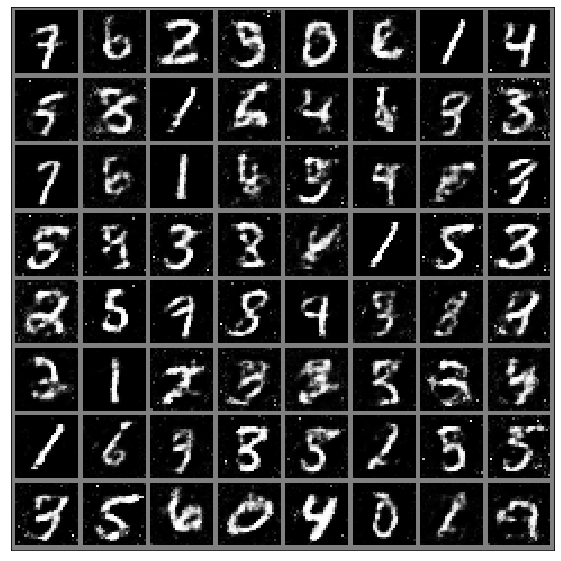

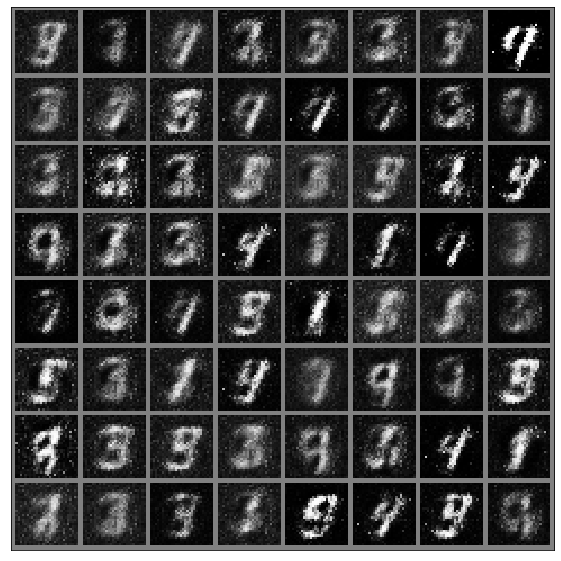

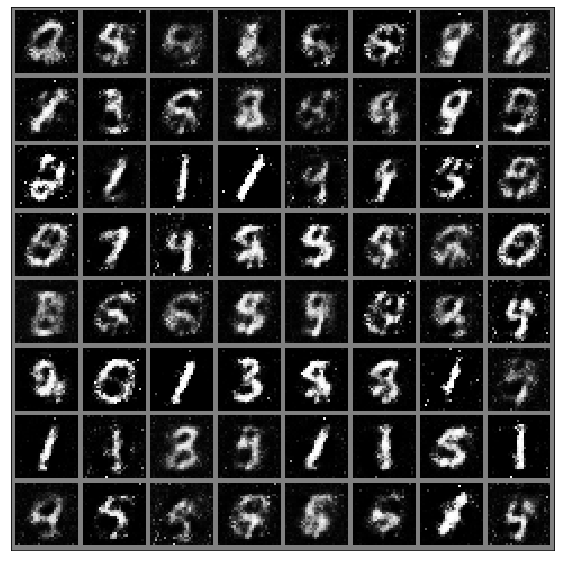

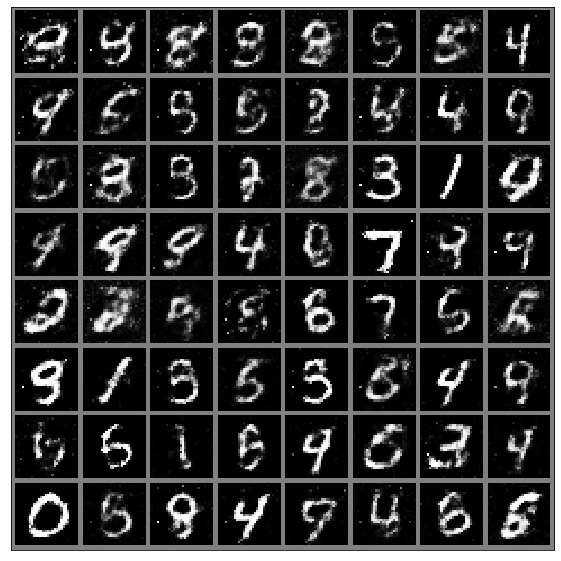

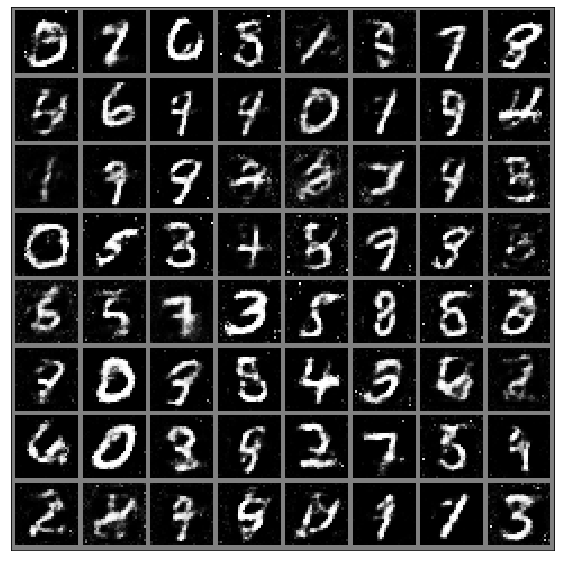

In [0]:
def show_generator_results(batch_vectors: np.array):
  with torch.no_grad():
    test_z = torch.Tensor(batch_vectors).to(device)
    generated = G(test_z)
        
    grid = make_grid(generated.view(generated.size(0), 1, 28, 28)).cpu().numpy()[0]
    show_in_row([grid], disable_ticks=True)

show_generator_results(np.random.rand(64, z_dim) * 2 - 1)    
for model in (10, 20, 50, 100):
  load_models(model)
  show_generator_results(np.random.rand(64, z_dim) * 2 - 1)

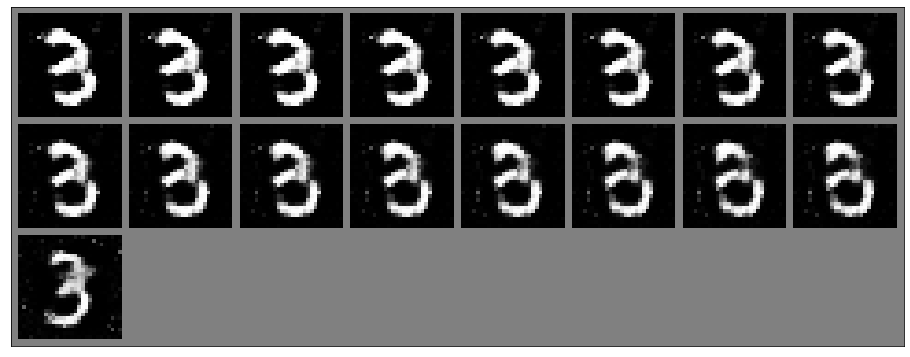

In [0]:
def generate_changing_vec(examples_count: int, vec_len: int) -> np.array:
    # return np.array of shape (examples_count, vec_len)
    vec1 = np.random.rand(1, vec_len)*2-1
    vec2 = np.random.rand(1, vec_len)*2-1
    vec3 = vec1 - vec2
    matrix = vec1
    # perform interpolation between vecs
    # use np.vstack to concatenate vectors!  

    for i in range(examples_count):
        gen = vec1 + i/(examples_count) * vec2
        matrix = np.vstack((gen, matrix))
    matrix = np.vstack((matrix, vec2))

    return matrix 
  
a = generate_changing_vec(15, 100)
show_generator_results(a)